# Imports

## general

In [1]:
import sys
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import OrderedDict
import seaborn as sns

## special tools

In [2]:
paths_to_functions = [
    os.path.join(os.path.abspath("../"), 'tools_for_analysis'),
    os.path.abspath("../../../../"),
]

for path in paths_to_functions:
    sys.path.append(path)

from get_reference_glaciers import get_experiment_gdirs, get_name_from_rgi_id

2025-04-04 11:27:17: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-04-04 11:27:17: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-04-04 11:27:17: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-04-04 11:27:17: oggm.workflow: init_glacier_directories by parsing all available folders (this takes time: if possible, provide rgidf instead).


In [ ]:
sys.path.append(os.path.abspath("../../"))

from graphics import get_fl_diagnostics, surf_to_nan
from create_glaciers_with_measurements import get_glacier_state_mb_model
from glaciers_for_idealized_experiments import experiment_glaciers

# Default folders

In [3]:
output_folder = os.environ["FIGURES_DIR"]

# Define colors

In [4]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [5]:
plt.style.use('seaborn-v0_8-colorblind')

# Get reference gdris

In [6]:
gdirs = get_experiment_gdirs()

# general help functions

In [7]:
def get_fl_plotting(gdir, glacier_states):
    fls_plotting = []
    for glacier_state in glacier_states:
        fls_plotting.append(
            gdir.read_pickle('model_flowlines',
                             filesuffix='_agile_true_init_'
                             f'{glacier_state}')[0])
    return fls_plotting

In [8]:
def define_max_extent(fls_plotting, grid_points_added):
    # define extend to plot according to longest flowline
    max_grid_point = 0
    for fl in fls_plotting:
        max_grid_point = np.max(
            [max_grid_point,
             np.argwhere(fl.thick > 0)[-1][0] + 1])
    max_grid_point += grid_points_added
    return max_grid_point

In [9]:
def get_x_coordinates(max_grid_point, fl):
    return np.arange(max_grid_point) * fl.dx * fl.map_dx / 1000

In [10]:
def get_volume_along_fl(fl):
    return fl.section * fl.dx_meter

# glacier geometry plot

In [11]:
def plot_bed_hypsometry(fig, ax, gdir,
                        glacier_states=['retreating',
                                        'equilibrium',
                                        'advancing'],
                        colors=['C0', 'C1', 'C2'],
                        grid_points_added=5,
                        plot_non_trap=True,
                        bins=20,
                        legend_x_position=0.8,
                        legend_y_position=1.0,
                       ):
    # open flowlines to be plotted (only for single flowline models)
    fls_plotting = get_fl_plotting(gdir, glacier_states)

    max_grid_point = define_max_extent(fls_plotting, grid_points_added)

    # Compute area histo
    def compute_area_histo(fls):
        area = np.array([])
        height = np.array([])
        bed = np.array([])

        a = fls.widths_m[:max_grid_point] * fls.dx_meter * 1e-6
        a = np.where(fls.thick[:max_grid_point] > 0, a, 0)
        area = np.concatenate((area, a))
        height = np.concatenate((height, fls.surface_h[:max_grid_point]))
        bed = np.concatenate((bed, fls.bed_h[:max_grid_point]))
        return area, height, bed

    areas = []
    heights = []
    beds = []

    for fl in fls_plotting:
        area_fl, height_fl, bed_fl = compute_area_histo(fl)
        areas.append(area_fl)
        heights.append(height_fl)
        beds.append(bed_fl)

    ylim = [np.min([bed.min() for bed in beds]),
            np.max([height.max() for height in heights]) + 300]

    # Plot histo
    posax = ax.get_position()
    posax = [posax.x0 + 2 * posax.width / 3.0,
             posax.y0, posax.width / 3.0,
             posax.height]
    axh = fig.add_subplot(frameon=False, zorder=4)
    axh.set_position(posax)

    for area, height, lw, color, histtype in zip(
        areas,
        heights,
        [1, 2.1, 1.4],  # lw
        colors,
        ['bar', 'step', 'step'],  # histtype
    ):
        axh.hist(height, orientation='horizontal', range=ylim, bins=bins,
                 alpha=1, weights=area, color=color,
                 histtype=histtype,
                 lw=lw
                 )

    axh.invert_xaxis()
    axh.xaxis.tick_top()
    axh.set_xlabel('Area [km$^2$]')
    axh.xaxis.set_label_position('top')
    axh.set_ylim(ylim)
    axh.yaxis.set_ticks_position('right')
    axh.set_yticks([])
    axh.axhline(y=ylim[1], color='black', alpha=1)  # qick n dirty trick
    axh.grid(False)

    # plot Centerlines
    x = get_x_coordinates(max_grid_point, fls_plotting[0])

    # Plot the bed
    ax.plot(x, fls_plotting[0].bed_h[:max_grid_point],
                color='k', linewidth=2.5, label=r'glacier bed')

    if plot_non_trap:
        for fl in fls_plotting:
            # Where not trapezoid change color
            bed_no_t = fl.bed_h[:max_grid_point] * np.NaN
            pt = (~fl.is_trapezoid[:max_grid_point]) | fl.is_rectangular[:max_grid_point]
            bed_no_t[pt] = fl.bed_h[:max_grid_point][pt]
            ax.plot(x, bed_no_t, '*', color='red', linewidth=2.5, ms=10,
                    zorder=90)

    def plot_glacier_surface(fl, label, color):
        surfh = surf_to_nan(fl.surface_h[:max_grid_point],
                            fl.thick[:max_grid_point])
        ax.plot(x, surfh,
                color=color, linewidth=2,
                label=label)

    # Plot glacier surface start, rgi, end
    for fl, state, color in zip(fls_plotting, glacier_states, colors):
        plot_glacier_surface(
            fl,
            label=state,
            color=color)

    ax.set_ylim(ylim)

    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Distance along flowline [km]')
    ax.set_ylabel('Altitude [m]')

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    # only for glacier bed
    legend1 = ax.legend(
        [handles[0]], [labels[0]],
        loc='lower left',
        handlelength=1.0,      # Shorter line in legend
        handletextpad=0.5,     # Reduce space between line and text
        columnspacing=0.5,     # Reduce space between columns
        #bbox_to_anchor=(0.5, 0.1)
    )
    ax.add_artist(legend1)
    # rest of the labels
    by_label = OrderedDict(zip(labels[1:], handles[1:]))
    legend2 = ax.legend(
        list(by_label.values()), list(by_label.keys()),
        loc='upper center',
        #bbox_to_anchor=(legend_x_position, legend_y_position),
        ncols=3,
        handlelength=1.0,      # Shorter line in legend
        handletextpad=0.5,     # Reduce space between line and text
        columnspacing=1.0,     # Reduce space between columns
        frameon=True)
    ax.add_artist(legend2)

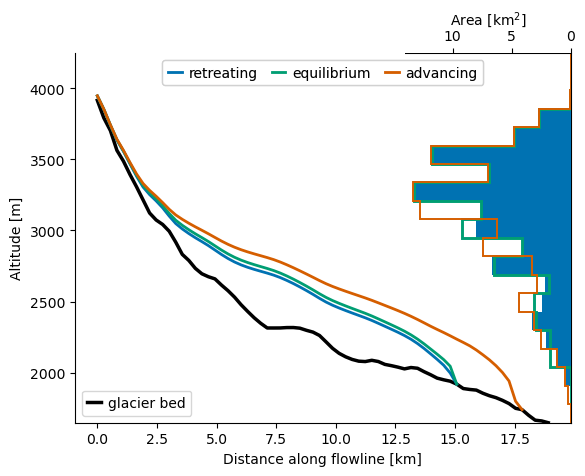

In [12]:
fig, ax = plt.subplots(1, 1)

plot_bed_hypsometry(fig, ax, gdirs[1],
                    glacier_states=['retreating',
                                    'equilibrium',
                                    'advancing'],
                    colors=['C0', 'C1', 'C2'],
                    grid_points_added=5,
                    plot_non_trap=True,
                    bins=20,
                    legend_x_position=0.1,
                    legend_y_position=1.0,)

# volume along flowline

In [13]:
def plot_volume_along_fl(ax,
                         gdir,
                         glacier_states=['retreating',
                                         'equilibrium',
                                         'advancing'],
                         colors=['C0', 'C1', 'C2'],
                         grid_points_added=5,
                         scale_by_length=True,
                        ):
    # get flowlines for plotting
    fls_plotting = get_fl_plotting(gdir, glacier_states)

    max_grid_point = define_max_extent(fls_plotting, grid_points_added)
    x = get_x_coordinates(max_grid_point, fls_plotting[0])

    for fl, glacier_state, color in zip(fls_plotting, glacier_states, colors):
        volume_along_fl = get_volume_along_fl(fl)[:max_grid_point] / 1e9
        if scale_by_length:
            volume_along_fl /= fl.dx_meter
        ax.plot(x, volume_along_fl,
                c=color,
                label=glacier_state,
               )

    if scale_by_length:
        ax.set_ylabel('Volume [km³]\nper unit length')
    else:
        ax.set_ylabel('Volume per\ngrid cell [km³]')
    ax.set_xlabel('Distance along flowline [km]')

    ax.set_ylim([0, None])

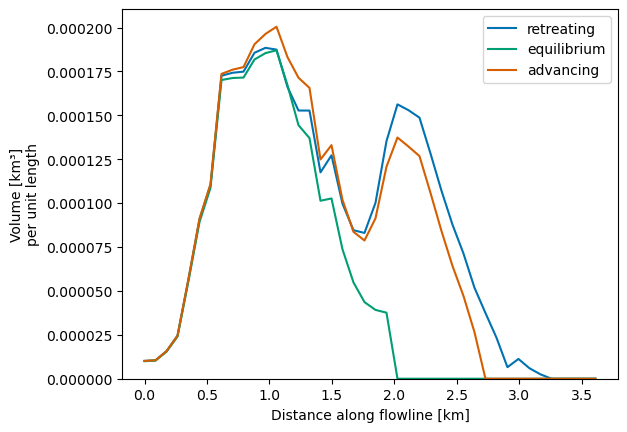

In [14]:
fig, ax = plt.subplots(1, 1)
plot_volume_along_fl(ax, gdirs[0])
ax.legend()

# first guess of glcier bed

In [15]:
def plot_first_guess_bed(ax,
                         gdir,
                         glacier_states=['retreating',
                                         'equilibrium',
                                         'advancing'],
                         colors=['C0', 'C1', 'C2'],
                         grid_points_added=5):
    # get flowlines for plotting
    fls_plotting = get_fl_plotting(gdir, glacier_states)

    max_grid_point = define_max_extent(fls_plotting, grid_points_added)
    x = get_x_coordinates(max_grid_point, fls_plotting[0])

    # get fg flowlines
    fls_oggm = []
    fls_glabtop = []
    for glacier_state in glacier_states:
        fls_oggm.append(
            gdir.read_pickle('model_flowlines',
                             filesuffix='_oggm_first_guess_'
                             f'{glacier_state}')[0])
        fls_glabtop.append(
            gdir.read_pickle('model_flowlines',
                             filesuffix='_glabtop_first_guess_'
                             f'{glacier_state}')[0])

    for fl, fl_oggm, fl_glabtop, color, glacier_state in zip(
        fls_plotting, fls_oggm, fls_glabtop, colors, glacier_states
    ):
        bed_diff_oggm = fl_oggm.bed_h[:max_grid_point] - fl.bed_h[:max_grid_point]
        ax.plot(x, bed_diff_oggm,
                c=color,
                label=glacier_state + ' OGGM')
        print(f'  Abs. Max diff {glacier_state} OGGM: {np.max(np.abs(bed_diff_oggm)):.1f} m')

        bed_diff_glabtop = fl_glabtop.bed_h[:max_grid_point] - fl.bed_h[:max_grid_point]
        ax.plot(x, bed_diff_glabtop,
                '--',
                c=color,
                label=glacier_state + ' GlabTop')
        print(f'  Abs. Max diff {glacier_state} GlabTop: {np.max(np.abs(bed_diff_glabtop)):.1f} m')

    ax.axhline(0, ls='-', color='black', zorder=0,)

    ax.set_ylabel('Diff. bed height [m]')
    ax.set_xlabel('Distance along flowline [km]')

  Abs. Max diff retreating OGGM: 19.4 m
  Abs. Max diff retreating GlabTop: 132.3 m
  Abs. Max diff equilibrium OGGM: 3.1 m
  Abs. Max diff equilibrium GlabTop: 9.2 m
  Abs. Max diff advancing OGGM: 11.6 m
  Abs. Max diff advancing GlabTop: 48.3 m


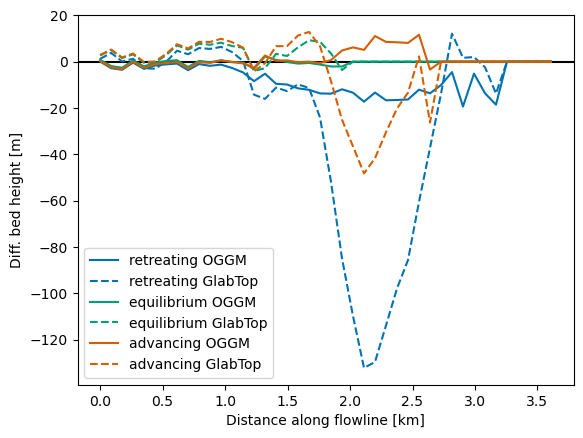

In [16]:
fig, ax = plt.subplots(1, 1)
plot_first_guess_bed(ax, gdirs[0])
ax.legend()

# Glacier creation plot

In [17]:
def plot_specific_mb(ax,
                     gdir,
                     glacier_states=['retreating',
                                     'equilibrium',
                                     'advancing'],
                     colors=['C0', 'C1', 'C2'],
                     ys=1980,
                     ye=2020):
    # define mass balance models to use
    fls_spinup = gdir.read_pickle('model_flowlines',
                                  filesuffix='_consensus')

    mb_model_runs = []
    for glacier_state in glacier_states:
        mb_model_runs.append(
            get_glacier_state_mb_model(gdir,
                                       glacier_state,
                                       fls_spinup=fls_spinup))

    fls_plotting = get_fl_plotting(gdir, glacier_states)

    for fls, mb_model_run, glacier_state, color in zip(
        fls_plotting, mb_model_runs, glacier_states, colors
    ):
        # read out mb values
        specific_mb = []
        years = np.arange(ys, ye)
        for yr in years:
            specific_mb.append(mb_model_run.get_specific_mb(fls=[fls], year=yr))
    
        ax.plot(years, specific_mb,
                c=color,
                zorder=10,
                label=glacier_state,
                )

    ax.axhline(0, ls='--', color='black', zorder=0, alpha=0.5)

    ax.set_ylabel('Mass-Balance\n[mm w.e. yr⁻¹]')

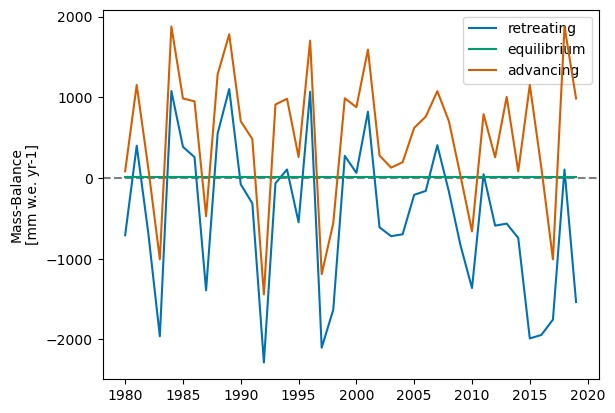

In [18]:
fig, ax = plt.subplots(1, 1)
plot_specific_mb(ax, gdirs[0])
ax.legend()


# Totel volume evolution

In [19]:
def plot_volume_evolution(
    ax,
    gdir,
    glacier_states=['retreating',
                    'equilibrium',
                    'advancing'],
    colors=['C0', 'C1', 'C2'],
    text_position=1.1,
    add_text=True,
    ys=1980,
    ye=2020,
):

    for glacier_state, color in zip(glacier_states, colors):
        # open actual historical run
        with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                               filesuffix='_agile_true_total_run_'
                                                          f'{glacier_state}')) as ds:
            ds_run = ds.load()
    
    
        # plot volume
        ax.plot(ds_run.time, ds_run.volume_m3 * 1e-9, color=color, label=glacier_state)

    ax.set_ylabel('Volume\n[km³]')

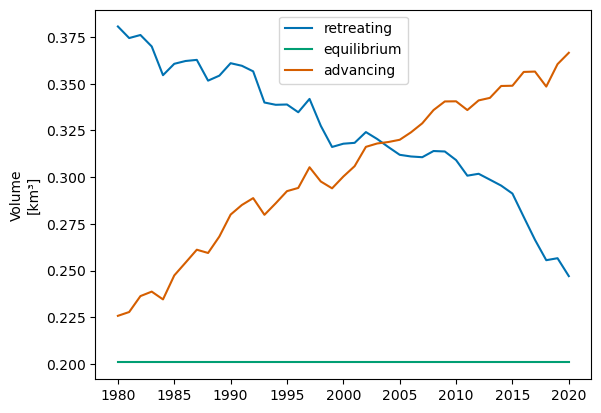

In [20]:
fig, ax = plt.subplots(1, 1)
plot_volume_evolution(ax, gdirs[0])
ax.legend()

# final plot glacier geomtery creation with time plot

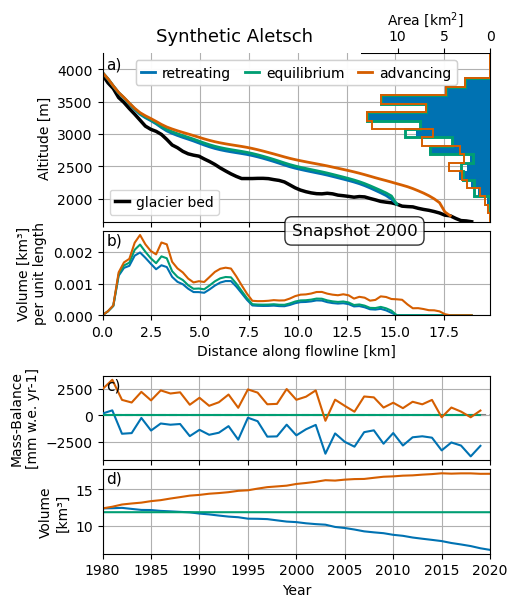

In [24]:
panel_labels = ['a)', 'b)', 'c)', 'd)']
for gdir in gdirs[1:2]:
    #with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(5, 6.5))
    
    gs = GridSpec(5, 1, height_ratios=[2, 1, 0.5, 1, 1], hspace=0.1)
    
    ax1 = fig.add_subplot(gs[0, 0], zorder=3)
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[3, 0])
    ax4 = fig.add_subplot(gs[4, 0])
    
    plot_bed_hypsometry(fig, ax1,
                        gdir,
                        glacier_states=['retreating',
                                        'equilibrium',
                                        'advancing'],
                        colors=['C0', 'C1', 'C2'],
                        grid_points_added=5,
                        plot_non_trap=True,
                        bins=20,
                        legend_x_position=0.3,
                        legend_y_position=0.5,)
    
    plot_volume_along_fl(ax2, gdir)
    
    # style the different axis
    ax1.set_xlabel('')
    ax1.set_xticklabels('');
    ax1.text(0.34, 1.05,
             f'Synthetic {get_name_from_rgi_id(gdir.rgi_id)}',
             va='bottom',
             ha='center',
             fontsize=13,
             transform=ax1.transAxes,
            )
    ax1.text(0.65, -0.01,
             f'Snapshot 2000',
             va='top',
             ha='center',
             fontsize=12,
             transform=ax1.transAxes,
             bbox=dict(
                    boxstyle="round,pad=0.4",  # Rounded edges with padding
                    edgecolor="black",         # Border color
                    facecolor="white",         # Background color
                    alpha=0.8                 # Transparency level
                )
            )

    ax1.set_xlim([0, None])
    ax2.set_xlim([0, None])
    #fig.tight_layout()

    plot_specific_mb(ax3, gdir)
    
    plot_volume_evolution(ax4, gdir)

    # style the different axis
    ax3.set_xlabel('')
    ax3.set_xticklabels('');
    #ax3.set_title(f'{get_name_from_rgi_id(gdir.rgi_id)} dynamic creation')
    #ax2.legend()
    ax4.set_xlabel('Year')
    ax3.set_xlim([1980, 2020])
    ax4.set_xlim([1980, 2020])

    for panel_label, ax in zip(panel_labels,
                               [ax1, ax2, ax3, ax4]):
        ax.text(
            0.01, 0.98, panel_label,
            va='top',
            ha='left',
            transform=ax.transAxes,
            fontsize=11,
            zorder=10,
        )

    ax1.grid('on')
    ax2.grid('on')
    ax3.grid('on')
    ax4.grid('on')
    
    plt.savefig(os.path.join(
        output_folder,
        f'{get_name_from_rgi_id(gdir.rgi_id)}_geometry_creation.png'),
                dpi=300, bbox_inches='tight')

## three glaciers in a row

In [22]:
def plot_for_a_single_glacier(gdir, axs, panel_labels):
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    ax4 = axs[3]
    
    plot_bed_hypsometry(fig, ax1,
                        gdir,
                        glacier_states=['retreating',
                                        'equilibrium',
                                        'advancing'],
                        colors=['C0', 'C1', 'C2'],
                        grid_points_added=5,
                        plot_non_trap=True,
                        bins=20,
                        legend_x_position=0.3,
                        legend_y_position=0.5,)
    
    plot_volume_along_fl(ax2, gdir)
    
    # style the different axis
    ax1.set_xlabel('')
    ax1.set_xticklabels('');
    ax1.text(0.34, 1.05,
             f'Synthetic {get_name_from_rgi_id(gdir.rgi_id)}',
             va='bottom',
             ha='center',
             fontsize=13,
             transform=ax1.transAxes,
            )
    ax1.text(0.65, -0.01,
             f'Snapshot 2000',
             va='top',
             ha='center',
             fontsize=12,
             transform=ax1.transAxes,
             bbox=dict(
                    boxstyle="round,pad=0.4",  # Rounded edges with padding
                    edgecolor="black",         # Border color
                    facecolor="white",         # Background color
                    alpha=0.8                 # Transparency level
                )
            )

    ax1.set_xlim([0, None])
    ax2.set_xlim([0, None])
    #fig.tight_layout()

    plot_specific_mb(ax3, gdir)
    
    plot_volume_evolution(ax4, gdir)

    # style the different axis
    ax3.set_xlabel('')
    ax3.set_xticklabels('');
    #ax3.set_title(f'{get_name_from_rgi_id(gdir.rgi_id)} dynamic creation')
    #ax2.legend()
    ax4.set_xlabel('Year')
    ax3.set_xlim([1980, 2020])
    ax4.set_xlim([1980, 2020])

    for panel_label, ax in zip(panel_labels,
                               [ax1, ax2, ax3, ax4]):
        ax.text(
            0.01, 0.98, panel_label,
            va='top',
            ha='left',
            transform=ax.transAxes,
            fontsize=11,
            zorder=10,
        )

    ax1.grid('on')
    ax2.grid('on')
    ax3.grid('on')
    ax4.grid('on')
    
    

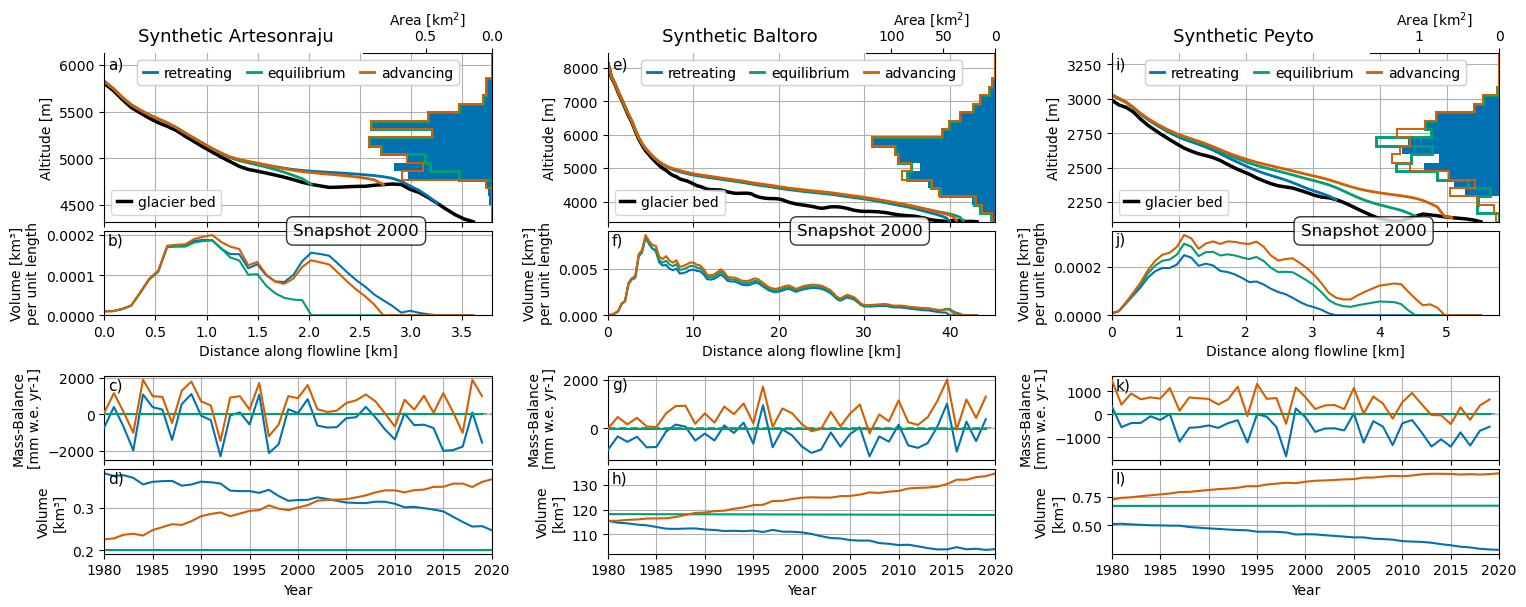

In [23]:
panel_labels_all = [
    ['a)', 'b)', 'c)', 'd)'],
    ['e)', 'f)', 'g)', 'h)'],
    ['i)', 'j)', 'k)', 'l)'],
]

fig = plt.figure(figsize=(18, 6.5))
    
gs = GridSpec(5, 3, height_ratios=[2, 1, 0.5, 1, 1], hspace=0.1, wspace=0.3)

axs_all = [
    [
        fig.add_subplot(gs[0, 0], zorder=3),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[3, 0]),
        fig.add_subplot(gs[4, 0]),
    ],
    [
        fig.add_subplot(gs[0, 1], zorder=3),
        fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[3, 1]),
        fig.add_subplot(gs[4, 1]),
    ],
    [
        fig.add_subplot(gs[0, 2], zorder=3),
        fig.add_subplot(gs[1, 2]),
        fig.add_subplot(gs[3, 2]),
        fig.add_subplot(gs[4, 2]),
    ],
]

for gdir, axs, panel_labels in zip([gdirs[0], gdirs[3], gdirs[2]], axs_all, panel_labels_all):
    plot_for_a_single_glacier(gdir, axs, panel_labels)

plt.savefig(os.path.join(
        output_folder,
        f'three_glaciers_geometry_creation.png'),
                dpi=300, bbox_inches='tight')

# first guess glacier bed

Artesonraju
  Abs. Max diff retreating OGGM: 19.4 m
  Abs. Max diff retreating GlabTop: 132.3 m
  Abs. Max diff equilibrium OGGM: 3.1 m
  Abs. Max diff equilibrium GlabTop: 9.2 m
  Abs. Max diff advancing OGGM: 11.6 m
  Abs. Max diff advancing GlabTop: 48.3 m
Aletsch
  Abs. Max diff retreating OGGM: 56.1 m
  Abs. Max diff retreating GlabTop: 96.0 m
  Abs. Max diff equilibrium OGGM: 39.5 m
  Abs. Max diff equilibrium GlabTop: 100.9 m
  Abs. Max diff advancing OGGM: 70.5 m
  Abs. Max diff advancing GlabTop: 162.2 m
Peyto
  Abs. Max diff retreating OGGM: 44.2 m
  Abs. Max diff retreating GlabTop: 61.8 m
  Abs. Max diff equilibrium OGGM: 19.4 m
  Abs. Max diff equilibrium GlabTop: 40.3 m
  Abs. Max diff advancing OGGM: 39.0 m
  Abs. Max diff advancing GlabTop: 43.4 m
Baltoro
  Abs. Max diff retreating OGGM: 35.0 m
  Abs. Max diff retreating GlabTop: 419.1 m
  Abs. Max diff equilibrium OGGM: 21.3 m
  Abs. Max diff equilibrium GlabTop: 398.9 m
  Abs. Max diff advancing OGGM: 39.6 m
  Abs. Ma

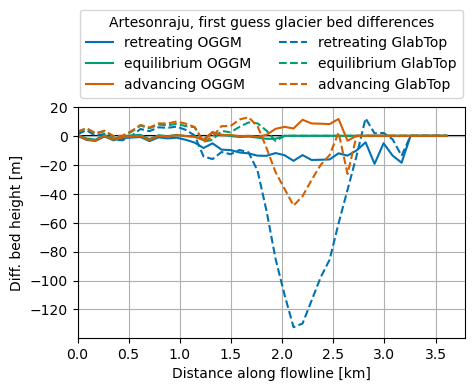

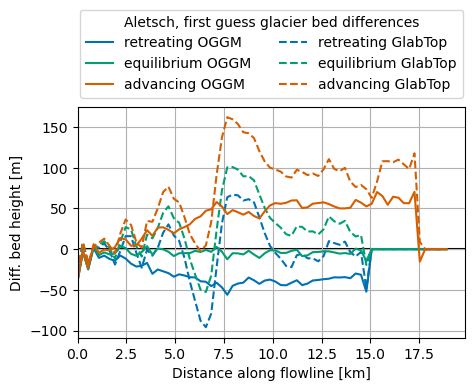

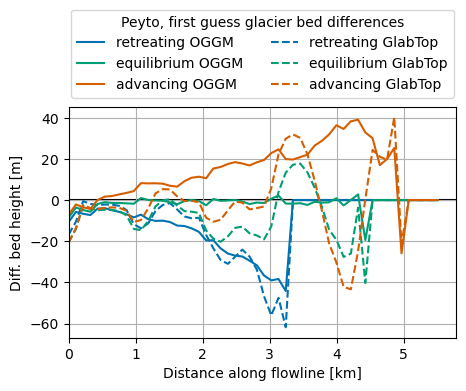

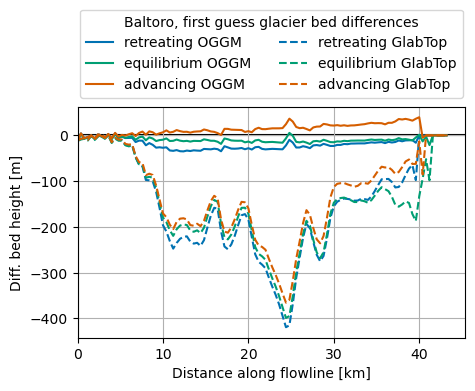

In [235]:
for gdir in gdirs:
    print(get_name_from_rgi_id(gdir.rgi_id))
    #with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    plot_first_guess_bed(ax, gdir)

    #ax.set_title(f'{get_name_from_rgi_id(gdir.rgi_id)} first guess glacier bed')

    # change order of legend entries
    handles, labels = ax.get_legend_handles_labels()
    order = [0, 2, 4, 1, 3, 5]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              title=f'{get_name_from_rgi_id(gdir.rgi_id)}, first guess glacier bed differences',
              loc='center',
              bbox_to_anchor=(0.5, 1.23),
              ncols=2)

    ax.grid('on')
    ax.set_xlim([0, None])

    plt.savefig(os.path.join(
        output_folder,
        f'{get_name_from_rgi_id(gdir.rgi_id)}_fg_bed.png'),
                dpi=300, bbox_inches='tight')